# Classification and clustering

Practical course material for the ASDM Class 09 (Text Mining) by Florian Leitner.

© 2016 Florian Leitner. All rights reserved.

In [22]:
# stdlib
import csv
import re
from collections import namedtuple, Counter
from html import unescape
from os import listdir
from urllib.parse import unquote

# numpy
import numpy as np

# gensim
from gensim.corpora import Dictionary
from gensim.corpora.wikicorpus import filter_wiki
from gensim.matutils import corpus2dense
from gensim.models import TfidfModel, LdaModel

# conda install scikit-learn
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# segtok
from segtok.segmenter import split_single
from segtok.tokenizer import web_tokenizer, split_contractions

Note that the above imports require you to have [SciKit-Learn](http://scikit-learn.org/stable/) installed. If you have not yet done so and are getting an error, you can [install](http://scikit-learn.org/stable/install.html) this library with `pip3 install scikit-learn` or `conda install scikit-learn`.

## Classifying the main genre of movie actors

Given a collection of actor Wikipedia pages and genre assignments of actors (the _examples_; according to Wikipedia), we will build a classifier that can predict the [main] genre (the _label_ or _class_) of actors given their Wikipedia page (the _case_ or _instance_).

In [23]:
CLASSES = ['action', 'western', 'director', 'drama']

### Loading the actor "corpus" (from Wikipedia)

Load the labeled movie actor corpus into memory.

In [24]:
corpus = {
    name: open('movie_actors/files/' + name, encoding='UTF-8').read()
    for name in listdir('movie_actors/files/')
}
actors = dict(l.strip().rsplit(",", 1) for l in \
              open('movie_actors/index.txt'))

Make sure our data is semantically correct.

In [25]:
def ensureEmpty(lst):
    assert len(lst) == 0, lst

# actors in index, missing from corpus:
ensureEmpty([a for a in actors if a not in corpus])
# actors in corpus, missing in index:
ensureEmpty([a for a in corpus if a not in actors])
# actor labels in corpus, missing in CLASSES:
ensureEmpty([l for l in set(actors.values()) if l not in CLASSES])
# class labels in CLASSES, missing in actors:
ensureEmpty([l for l in CLASSES if l not in set(actors.values())])

Parse the Wiki-formated documents to plain-text.

In [26]:
corpus = dict((name, filter_wiki(corpus[name])) for name in corpus)

In [27]:
print("documents: %i\nactors   : %i\nlabels   :   %i" %
      (len(corpus), len(actors), len(CLASSES)))

documents: 822
actors   : 822
labels   :   4


### Preparing the data and models for a document classification pipeline

Put the corpus into a convenient NumPy array format for batch processing.

In [28]:
y_raw, X_raw = zip(*[(actors[i], corpus[i]) for i in corpus])
y = np.array(y_raw)
X = np.array(X_raw)

Set up a SciKit-Learn pipeline.

In [30]:
TfidfVectorizer??

In [31]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             max_df=0.5,
                             stop_words='english')
classifier = LogisticRegression(class_weight='balanced')
# alternatively, you can try using a linear SVM classifier:
# classifier = LinearSVC(class_weight='balanced', loss='hinge')
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

### Evaluating the document classification pipeline

Evaluate the pipeline using _stratified_ 5-fold cross-validation.

Use stratified CV if you expect that the distribution of label priors (among instances to classify) is imbalanced, and if the imbalance in your corpus matches the imbalance you expect to see for documents you later want to classify.

In [ ]:
cross_validation = StratifiedKFold(y, n_folds=5, shuffle=True)

Note that it is important to make sure that the feature vectorizer (TF-IDF) is fitted only with training data, not with test data. This way we test classificaion _and_ __vectorization__ on "truly" unseen data; Although, technically, after you've run this tool even once, we are starting to bias our pipeline towards the corpus data
if varying any parameter to improve the performance...

In [ ]:
for fold, (train, test) in enumerate(cross_validation):
    # Train ("fit")
    pipeline.fit(X[train], y[train])
    # Test ("predict")
    predictions = pipeline.predict(X[test])
    # Print results
    print('\nmicro-F1: %.3f' % f1_score(y[test], predictions, pos_label=None, average='micro'))
    print('macro-weighted: %.3f' % f1_score(y[test], predictions, pos_label=None, average='weighted'))
    print(', '.join('%s: %.3f' % (CLASSES[i], s) for i, s in enumerate(f1_score(y[test], predictions, average=None))))

The classifier can separate our documents with reasonable performance, although it is far from perfect. Probably good enough for writing an academic paper, but certainly far from the error rates typically acceptable in production settings; Just imagine if 10% of your good mail were classified as spam, or 10% of your spam mail were not filtered...

In [ ]:
from collections import Counter
Counter(actors.values())

## Clustering movie actors by topic similarity

Given the same collection of actor pages, we will (attempt to...) cluster similar actors into _topics_ using Latent Dirichlet Alloction.

### Building an inverted index

Above we used the SciKit-Learn vectorizer to tokenize the data and generate n-grams.
Here, we will build our own vectorizer that tokenizes the corpus and generates n-grams.

In [32]:
tokens = {
    doc: tuple(
        tuple(t.lower() for t in web_tokenizer(s) if t.isalnum())
        for s in split_single(corpus[doc])
    ) for doc in corpus
}

In [34]:
def generateNGrams(sentences, n):
    """Generate all possible n-grams from 1 up to size n."""
    for s in sentences:
        for i in range(n):
            if len(s) > i:
                for j in range(1, len(s) - i):
                    yield ' '.join(s[j - 1:j + i])


ngrams = {doc: list(generateNGrams(tokens[doc], 2)) for doc in tokens}

Next, we build the inverted index that maps n-gram counts to  documents. In other words, we are building a matrix of documents times n-grams (`words`).

In [35]:
# Note that names, docs, and matrix must all be in the same order
names = list(corpus.keys())
names_clean = [unquote(n).replace("_", " ")[:-4] for n in names]
docs = [ngrams[doc] for doc in names]
# Map all 1 to n n-grams to unique IDs
words = Dictionary(docs)
print("corpus contains %i unique words" %
      len(words))
# Remove all n-grams that occur less than five times
# or in more than half the documents
words.filter_extremes(keep_n=None)
print("after pruning there are %i unique words" %
      len(words))
# Generate the inverted index (n-grams times documents)
# as a sparse matrix
matrix = [words.doc2bow(d) for d in docs]
print("inverted index: a (sparse row-) matrix of %i documents x %i words" %
      (len(matrix), len(words)))

corpus contains 571443 unique words
after pruning there are 46718 unique words
inverted index: a (sparse row-) matrix of 822 documents x 46718 words


### Latent dirichlet allocation of topics

Next, we build the LDA model for `NUM_TOPICS` topics, using TF-IDF transformed "words".

In [36]:
NUM_TOPICS = 20 # hyperparameter

tfidf = TfidfModel(matrix)
lda = LdaModel(tfidf[matrix],
               id2word=words,
               num_topics=NUM_TOPICS)

Let's inspect the top (most likely) words for each topic to "understand" what each cluster we generated is about.

In [37]:
for i in range(NUM_TOPICS):
    print('Topic %i:' % (i + 1), ', '.join(
            '%s (p=%.2e)' % (w, p) for (w, p) in
            lda.show_topic(i, 10)))

Topic 1: kidman (p=2.74e-04), lyons (p=2.71e-04), waters (p=2.69e-04), malick (p=2.35e-04), chow (p=2.26e-04), rey (p=2.22e-04), dreyer (p=2.16e-04), ray (p=1.96e-04), award for (p=1.93e-04), hitchcock (p=1.88e-04)
Topic 2: episode (p=3.94e-04), polanski (p=2.70e-04), 1936 (p=2.66e-04), chan (p=2.59e-04), episode the (p=2.58e-04), anderson (p=2.30e-04), elliott (p=2.25e-04), for best (p=2.24e-04), mcclure (p=2.17e-04), hughes (p=2.16e-04)
Topic 3: lundgren (p=2.96e-04), scott (p=2.87e-04), anders (p=2.85e-04), tarantino (p=2.78e-04), innocent (p=2.65e-04), hawke (p=2.60e-04), episode (p=2.50e-04), larue (p=2.36e-04), regal (p=2.32e-04), diesel (p=2.00e-04)
Topic 4: episode (p=5.68e-04), episode the (p=4.18e-04), stewart (p=2.87e-04), lubitsch (p=2.60e-04), carradine (p=2.55e-04), sheriff (p=2.47e-04), devine (p=2.42e-04), borgnine (p=2.31e-04), mendes (p=2.25e-04), dutt (p=2.25e-04)
Topic 5: jeffries (p=3.11e-04), hughes (p=3.04e-04), preminger (p=2.99e-04), streep (p=2.96e-04), episod

### Plotting the clustering result in two dimensions

To visualze the LDA result, we need to embed the high-dimensional data into a two-dimensional plane we can plot. This is what [t-SNA](https://lvdmaaten.github.io/tsne/) (t-distributed stochastic neighbor embedding) is about; Imagine it as a "distance-preserving PCA". SciKit-Learn provides an implementation.

In [38]:
X = corpus2dense(lda[tfidf[matrix]], len(words))
X_tsne = TSNE(n_components=2, perplexity=20, verbose=1)
X_embedded = X_tsne.fit_transform(X.transpose())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 822 / 822
[t-SNE] Mean sigma: 0.131139
[t-SNE] Error after 100 iterations with early exaggeration: 0.585261
[t-SNE] Error after 175 iterations: 0.528880


First, switch to interactive plot mode, so you can zoom in on some region.

In [39]:
%pylab --no-import-all notebook

Populating the interactive namespace from numpy and matplotlib


Before plotting the t-SNE embedded result, we label every document with the actor name.

<IPython.core.display.Javascript object>


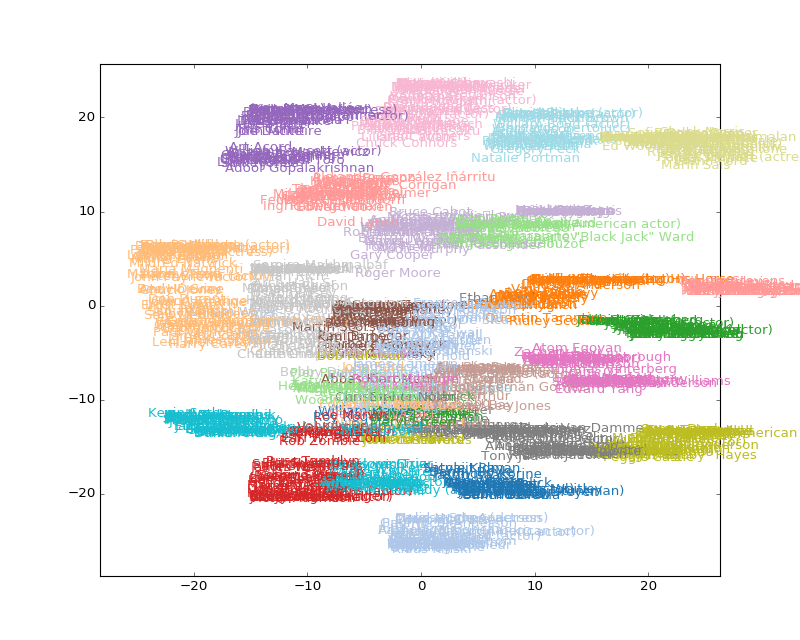

In [40]:
plt.figure(figsize=(10,8))
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", 
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5", 
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", 
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

plt.plot()

border = max(X_embedded[:, 0]) / 10.0
plt.axis([
    min(X_embedded[:, 0]) - border,
    max(X_embedded[:, 0]) + border,
    min(X_embedded[:, 1]) - border,
    max(X_embedded[:, 1]) + border
])

i = 0
for x, y, n in zip(X_embedded[:, 0],
                   X_embedded[:, 1],
                   names_clean):
    topics = lda.get_document_topics(tfidf[matrix[i]])
    main_topic = sorted(topics, key=lambda a: a[1])[-1][0]
    plt.text(x, y, n, color=colormap[main_topic])
    i += 1
    
plt.show()

Depending on your knowledge of movie actors, some of the above clusters might make sense or not... But in any case, you have seen a very interesting way of generating clusters and visualizing the data.

## Twitter opinion mining with a Support Vector Machine

Opinion mining (often called "sentiment analysis" to make it sound terribly sophisticated) is just a specfic incarnation of a document classification task. Therefore, this section adds nothing new to what we haven't explored already above and we will only work though this section in class if there is time left. If not, please feel encouranged go over this part "at home" if you are interested.

### Preparing the corpus

This section could be a helpful reference for working with CSV files in Python 3 and will show you how to prepare the raw twitter data as downloaded from the web.

In [ ]:
istream = open('twitter_corpus.csv', encoding='UTF-8')
csvstream = csv.reader(istream)

Reading off the first line:

In [ ]:
next(csvstream)

In [ ]:
Instance = namedtuple('Instance', 'tweet product emotion')

In [ ]:
corpus = [Instance(*row) for row in csvstream]
istream.close() # don't forget to close your resource handles
# (although Python will try to do it for you)

Unescape HTML escape sequences ("`&amp;`" => "&")

In [ ]:
corpus = [i._replace(tweet=unescape(i.tweet)) for i in corpus]

Despite the number of lines in the file being 9289, the CSV reader took care of multiline tweets for us!

In [ ]:
len(corpus)

Here is a nifty Python idiom for splitting rows with a fixed number of columns in each row into separate variables for each column:

`col1, col2, ... = zip(*rows)`

In [ ]:
tweets, products, emotions = zip(*corpus)

In [ ]:
emotions = Counter(emotions)
emotions

In [ ]:
products = Counter(products)
products

In [ ]:
corpus[0]

In [ ]:
posneg_only = lambda i: i.emotion in ('Negative emotion', 'Positive emotion')
filtered = list(filter(posneg_only, corpus))
X = np.array([i.tweet for i in filtered])
y = np.array([i.emotion == 'Positive emotion' for i in filtered])
assert len(X) == len(y), "%i == %i" % (len(X), len(y))
len(y)

In [ ]:
X

In [ ]:
y

### Defining a simple, regex based tokenizer for the SciKit-Learn vectorizer

In [ ]:
sklearn_tokenizer = re.compile(r"(?u)\b\w\w+\b")

In [ ]:
tok = re.compile(r'http://\S+|:\-?[)(\]\[DPdp]|{link}|[@#\']?\w+(?:\-\w+)*|[^,\w\s#@]+')

In [ ]:
X[0]

In [ ]:
' '.join(sklearn_tokenizer.findall(X[0]))

In [ ]:
' '.join(tok.findall(X[0]))

In [ ]:
' '.join(sklearn_tokenizer.findall("smi-ley {link} @mention :( :) :D :P :-( :-) :-D :-P ... !?!"))

In [ ]:
' '.join(tok.findall("smi-ley {link} @mention :( :) :D :P :-( :-) :-D :-P ... !?!"))

In [ ]:
' '.join(tok.findall("What !?!? @mention  #SXSW does not provide iPhone chargers?!?  I've changed my mind about going next year!"))

In [ ]:
X[10]

In [ ]:
' '.join(sklearn_tokenizer.findall(X[10]))

In [ ]:
' '.join(tok.findall(X[10]))

### Setting up the pipeline

In [ ]:
vectorizer = TfidfVectorizer(sublinear_tf=False,
                             smooth_idf=True,
                             stop_words='english',
                             token_pattern=r'http://\S+|:\-?[)(\]\[DPdp]|[@#]?\w+(?:\-\w+)*|[^,\w\s#@]+',
                             ngram_range=(1, 3))
classifier = LinearSVC(class_weight='balanced', loss='hinge')
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])
cross_validation = StratifiedKFold(y, n_folds=5, shuffle=True)

In [ ]:
def evaluate(X, y):
    for fold, (train, test) in enumerate(cross_validation):
        # Train ("fit")
        pipeline.fit(X[train], y[train])
        # Test ("predict")
        predictions = pipeline.predict(X[test])
        # Print results
        print('\nAccuracy: %.3f' % accuracy_score(y[test], predictions))
        # The majority label is True, and it is harder to detect negative tweets.
        # Therefore, we must switch True and False for the F-measure:
        print('F1-Score: %.3f' % f1_score(y[test] == False, predictions == False))
        print('MCC score: %.3f' % matthews_corrcoef(y[test], predictions))
        # Report errors and print one FP and one FN example
        reportErrors(X[test], y[test], predictions)

def reportErrors(tweets, labels, predictions):
    errors = tweets[labels != predictions]
    error_labels = predictions[labels != predictions]
    print('Errors:', len(errors), '/', len(test),
          '= FPs:', sum(error_labels),
          '+ FNs:', len(errors) - sum(error_labels))
    FP_printed = False
    FN_printed = False
    
    for i in range(len(errors)):
        if (error_labels[i] and not FP_printed) or \
           (not error_labels[i] and not FN_printed):
            if error_labels[i]:
                FP_printed = True
                print('FP:', end=' ')
            else:
                FN_printed = True
                print('FN:', end=' ')
            print(errors[i])

### Evaluating the ad-hoc "sentiment" classifier

In [ ]:
evaluate(X, y)